## 【Python】【爬虫】爬取京东商品用户评论（分析+可视化）
https://blog.csdn.net/qq_34696236/article/details/80511940

In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
import requests, csv, codecs, json
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from urllib.parse import urlencode

In [2]:
# 1、要取所有的电脑数据，首先得获得所有电脑的网页源码，以及url地址如下：
def download(url, headers, num_retries=3):
    print("download", url)
    try:
        response = requests.get(url, headers=headers)
        print(response.status_code)
        # 如果相应的状态码为：200 那么return 返回网站源码，如果访问非200则调用重试
        if response.status_code == 200:
            return response.content
        return None
    except RequestException as e:
        print(e.response)
        html = ""
        if hasattr(e.response, 'status_code'):
            code = e.response.status_code
            print('error code', code)
            if num_retries > 0 and 500 <= code < 600:
                html = download(url, headers, num_retries - 1)
        else:
            code = None
    return html

In [3]:
# 取得 商品(pID)頁面
def get_html(pID, page):
    url = f"https://sclub.jd.com/comment/productPageComments.action?productId={pID}&score=0&sortType=5&page={page}&pageSize=10&isShadowSku=0&fold=1"
    headers = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36',
        'referer':'https://item.jd.com/{pID}.html'
    }
    res = requests.get(url, headers=headers)
    return res.text

In [4]:
def get_json(url):
    data = requests.get(url).json()
    #print(data)
    result = data['CommentsCount']
    for i in result:
        return i["CommentCountStr"], i["GoodRateShow"]

In [5]:
def write_csv(csv_name, data_list):
    with open(csv_name, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        fields = ('PID', 'NAME', 'PRICE', 'CommentCount', 'GoodRate', 'creationTime', 'nickname', 'content')
        writer.writerow(fields)
        for data in data_list:
            writer.writerow(data)

In [6]:
def find_Product(url, headers, page_comment):
    r = download(url, headers=headers)
    #print(r)
    page = BeautifulSoup(r, "lxml")
    #print(page.prettify())
   
    all_items = page.find_all('li', attrs={'class':'gl-item'})
    data_list = []
    
    for all in all_items:
        product_id = all["data-sku"]
        product_name = all.find('div', attrs={'class': 'p-name p-name-type-2'}).find('em').text
        _price = all.find('div', attrs={'class': 'p-price'}).find('strong')
        product_price = _price.get('data-price', _price.find('i').text)

        # 取每台電腦的Json數據(包含 評價等等信息)
        URL_summary = f"https://club.jd.com/comment/productCommentSummaries.action?referenceIds={product_id}"
        comment_count, good_rate = get_json(URL_summary)
        for p in range(page_comment):
            data = json.loads(get_html(product_id, p)) #'100005171461'
            for d in data['comments']:
                row = []
                row.append(product_id)
                row.append(product_name)
                row.append(str(product_price))
                row.append(comment_count)
                row.append(good_rate)
                row.append(d['creationTime'])
                row.append(d['nickname'])
                row.append(d['content'])               
                data_list.append(row)
    return data_list

In [7]:
def main(page_search, page_comment):
    headers = {
        'User-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36",
        "referer": "https://search.jd.com"
        }
    all_list = []
    
    for page in range(1,page_search*2+1,2):
        URL = f"https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page={page}&s=1&click=0"
        data_list = find_Product(URL, headers=headers, page_comment=page_comment)
        all_list += data_list
    write_csv("leovo.csv", all_list)

In [8]:
if __name__ == '__main__':
    main(2, 2)
    print("\nDONE\n")

download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=1&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=3&s=1&click=0
200

DONE



In [29]:
import pandas as pd
data = pd.read_csv('leovo.csv', encoding='utf-8-sig', dtype=str)
print('包含字段: \n'+'||'.join(data.columns))
data['creationTime']=pd.to_datetime(data['creationTime'])
data['creationTime'].describe()

包含字段: 
PID||NAME||PRICE||CommentCount||GoodRate||creationTime||nickname||content


count                    1200
unique                    640
top       2019-06-03 13:00:56
freq                        9
first     2017-10-15 12:38:23
last      2020-02-17 13:20:49
Name: creationTime, dtype: object

In [43]:
data['content'].describe()

count                                                  1200
unique                                                  638
top       做工不错，速度挺快，鲁大师平分21万，可以吃鸡！正常使用静音，打开游戏风扇呼呼的，充电器17...
freq                                                      9
Name: content, dtype: object

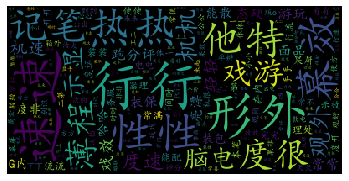

In [56]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba
train = data.astype(str)

for index, row in train.iterrows():
    words = jieba.cut(row['content'], cut_all = True)
    for word in words:
        wl_space_split += " ".join(word)
        #print(word)
        
font = r'C:\Windows\Fonts\simkai.ttf'        
my_wordcloud = WordCloud(collocations=False, font_path=font).generate(wl_space_split)
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()

my_wordcloud.to_file('show_Chinese.png')  # 把词云保存下来